In [1]:
import sys
from pathlib import Path
import __main__
if not hasattr(__main__, '__file__'): # notebook
    sys.path.append('../src') 
    pickle_dir = Path('..')
else: # exported python
    sys.path.append('src')
    pickle_dir = Path('.')
import time
import pickle
from collections import defaultdict

from multiprocessing import Pool
from tqdm import tqdm
import numpy as np
import sympy as sp
import warnings
import matplotlib.pyplot as plt
from liab.k_leg_liab import k_leg_liab
from liab.shapley_liab import shapley_liab
from liab.random_system import get_rand_system, rerand_system, get_rand_float_vec, get_rand_failure
from liab.failure import ClosedHalfSpaceFailureSet
from IPython.display import display, clear_output
from scipy.stats import mannwhitneyu
from scipy.stats import entropy


SEED = 42
NUM_WORKERS = 2
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# S = get_rand_system(6, 'linear', seed=SEED)
# T = rerand_system(S, seed=SEED+1)
# print(S)
# print(T)
# print(S.func_type, T.func_type)

System(cs=[ComponentOrEquation(I=['x_0'], O=x_2 (<class 'str'>), f=-25.09*x_0), ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_3 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2), ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_4 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2), ComponentOrEquation(I=['x_1', 'x_3'], O=x_5 (<class 'str'>), f=-25.09*x_1+90.14*x_3)])
System(cs=[ComponentOrEquation(I=['x_0'], O=x_2 (<class 'str'>), f=-76.99*x_0), ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_3 (<class 'str'>), f=-76.99*x_0+21.81*x_1-73.32*x_2), ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_4 (<class 'str'>), f=-76.99*x_0+21.81*x_1-73.32*x_2), ComponentOrEquation(I=['x_1', 'x_3'], O=x_5 (<class 'str'>), f=-76.99*x_1+21.81*x_3)])
linear linear


In [3]:
# M = S.induced_scm()
# N = T.induced_scm()
# print(M)
# print(N)
# print(M.func_type, N.func_type)

SCM(U={'x_1', 'x_0'}, V={'x_4', 'x_5', 'x_3', 'x_2'}, cs={'x_2': ComponentOrEquation(I=['x_0'], O=x_2 (<class 'str'>), f=-25.09*x_0), 'x_3': ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_3 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2), 'x_4': ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_4 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2), 'x_5': ComponentOrEquation(I=['x_1', 'x_3'], O=x_5 (<class 'str'>), f=-25.09*x_1+90.14*x_3)}, state_order=['x_2', 'x_3', 'x_4', 'x_5'])
SCM(U={'x_1', 'x_0'}, V={'x_4', 'x_5', 'x_3', 'x_2'}, cs={'x_2': ComponentOrEquation(I=['x_0'], O=x_2 (<class 'str'>), f=-76.99*x_0), 'x_3': ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_3 (<class 'str'>), f=-76.99*x_0+21.81*x_1-73.32*x_2), 'x_4': ComponentOrEquation(I=['x_0', 'x_1', 'x_2'], O=x_4 (<class 'str'>), f=-76.99*x_0+21.81*x_1-73.32*x_2), 'x_5': ComponentOrEquation(I=['x_1', 'x_3'], O=x_5 (<class 'str'>), f=-76.99*x_1+21.81*x_3)}, state_order=['x_2', 'x_3', 'x_4', 'x_5'])
linear linear


# cur

In [7]:
def get_exp_unit(args):
    num_vars, seed = args
    rnd = np.random.RandomState(seed)
    while True:
        S = get_rand_system(num_vars, 'linear', rnd=rnd)
        T = rerand_system(S, rnd=rnd)
        M = S.induced_scm()
        N = T.induced_scm()
        F = get_rand_failure(list(M.V)[:2], ClosedHalfSpaceFailureSet, rnd=rnd)
        u = F.get_example_context(M, N, seed=seed)
        if u:
            state_m, _ = M.get_state(u)
            state_n, _ = N.get_state(u)
            if not F.contains(state_m) and F.contains(state_n):
                return T, S, u, F
            
def do_exp(args):
    T, S, u, F, ks = args
    k_leg_values, shapley_values, k_leg_times, shapley_times = {}, {}, {}, {}
    start_time = time.time()
    shapley = shapley_liab(T, S, u, F, k=-1)
    shapley_time = time.time() - start_time
    for k in ks:
        start_time = time.time()
        k_leg = k_leg_liab(T, S, u, F, k=k)
        k_leg_times[k] = time.time() - start_time
        shapley_times[k] = shapley_time
        k_leg_values[k], shapley_values[k] = [], []
        for var in k_leg:
            k_leg_values[k].append(k_leg[var])
            if var in shapley:
                shapley_values[k].append(shapley[var])
            else:
                print(f'Warning: {var} not found in Shapley liability')

    return {'k_leg_values': k_leg_values, 'shapley_values': shapley_values,
        'k_leg_times': k_leg_times, 'shapley_times': shapley_times}

def experiment(num_vars, ks=[1,2], num_samples=20):
    print(f'Doing experiments ({num_samples=}) ...')
    units = []
    pbar = tqdm(total=num_samples)
    def update_progress_get_unit(unit):
        if unit:
            units.append(unit)
            pbar.update(1)
    def error_get_unit(e):
        raise e
    if NUM_WORKERS == 1:
        tasks = [(num_vars, i) for i in range(num_samples)]
        for task in tasks:
            try:
                unit = get_exp_unit(task)
                update_progress_get_unit(unit)
            except Exception as e:
                error_get_unit(e)
    else:
        with Pool(NUM_WORKERS) as pool:
            tasks = [(num_vars, i) for i in range(num_samples)]
            for task in tasks:
                pool.apply_async(get_exp_unit, args=(task,), callback=update_progress_get_unit, error_callback=error_get_unit)
            pool.close()
            pool.join()
    pbar.close()
    
    print(f'Processing results for k in {ks} ...')
    exp_results = {'k_leg_values':  defaultdict(list), 'shapley_values':  defaultdict(list),
        'k_leg_times': defaultdict(list), 'shapley_times': defaultdict(list)}
    pbar = tqdm(total=num_samples)
    def update_progress_do_exp(exp_result):
        if exp_result:
            for k in ks:
                for key in exp_result:
                    exp_results[key][k].append(exp_result[key][k])
            pbar.update(1)
    def error_do_exp(e):
        raise e
    if NUM_WORKERS == 1:
        tasks = []
        for unit in tqdm(units):
            T, S, u, F = unit
            tasks.append((T, S, u, F, ks))
        for task in tasks:
            sys.stdout.flush()
            try:
                exp_result = do_exp(task)
                update_progress_do_exp(exp_result)
            except Exception as e:
                error_do_exp(e)
    else:
        with Pool(NUM_WORKERS) as pool:
            tasks = []
            for unit in tqdm(units):
                T, S, u, F = unit
                tasks.append((T, S, u, F, ks))
            for task in tasks:
                sys.stdout.flush()
                pool.apply_async(do_exp, args=(task,), callback=update_progress_do_exp, error_callback=error_do_exp)
            pool.close()
            pool.join()
    pbar.close()
    
    return exp_results

def get_vargha_delaney(n1, n2, U):
    # Calculate Vargha and Delaney A effect size
    A = U / (n1 * n2)

    # Determine the effect size description
    if A >= 0.71 or A == 0:
        return f"large effect"
    elif A >= 0.64:
        return f"medium effect"
    elif A >= 0.56:
        return f"small effect"
    elif A >= 0.44:
        return f"negligible effect"
    else:
        return f"no effect"

def experiment_and_plot(num_vars, ks=[1,2], num_samples=20, use_pickle=False, pickle_dir='.'):
    pickle_fn = Path(pickle_dir) / f'{num_vars=}_{ks=}.pickle'
    if use_pickle:
        with open(pickle_fn, 'rb') as pickle_fd:
            exp_results = pickle.load(pickle_fd)
    else:
        exp_results = experiment(num_vars, ks=ks, num_samples=num_samples)
        with open(pickle_fn, 'wb') as pickle_fd:
            pickle.dump(exp_results, pickle_fd)
    
    k_leg_values, shapley_values, k_leg_times, shapley_times = tuple(exp_results.values())
    
    ents = defaultdict(list)
    for k in ks:
        for sublist1, sublist2 in zip(k_leg_values[k], shapley_values[k]):
            # mut is the L1 distance between k_leg and Shapley (each of these sum to 1)
            #   this is a number between 0 and 2 (0 no difference, 2 [1 0] - [0 1])
            mut = abs(np.array(sublist1) - sublist2).sum()
            ents[k].append(mut)

    fig, ax = plt.subplots(1, len(k_leg_times), figsize=(4*len(k_leg_times), 4))
    for ki, k in enumerate(k_leg_times):
        ax[ki].hist(ents[k], bins=50, alpha=0.7)
        # ax[ki].hist(shapley_falttened[k], bins=20, alpha=0.7, label=f'Shapley')
        # ax[ki].legend()
        # U, p_value = mannwhitneyu(shapley_falttened[k], k_leg_flattened[k], alternative='two-sided')
        # effect_size = get_vargha_delaney(len(k_leg_flattened[k]), len(shapley_falttened[k]), U)
        # ax[ki].set_title(f'p-vale={p_value:.3f}, effect={effect_size}')
        ax[ki].set_yscale('log')
        X = np.array(ents[k])
        good_X = X[X<.6] # .2 of max difference which is 2
        p_value = (len(X) - len(good_X)) / len(X) 
        print(f'{k=}: {p_value=}')
        # ax[1, ki].set_ylim([min(muts[k]), max(muts[k])])
    fig.suptitle(f'Liability difference (M={num_vars})', y=0.95)  # Position at the bottom
    fig.tight_layout()

    fig, ax = plt.subplots(1, len(k_leg_times), figsize=(4*len(k_leg_times), 4))
    for ki, k in enumerate(k_leg_times):
        ax[ki].hist(k_leg_times[k], bins=20, alpha=0.7, label=f'{k}-leg')
        ax[ki].hist(shapley_times[k], bins=20, alpha=0.7, label=f'Shapley')
        ax[ki].legend()
        U, p_value = mannwhitneyu(shapley_times[k], k_leg_times[k], alternative='greater')
        effect_size = get_vargha_delaney(len(k_leg_times[k]), len(shapley_times[k]), U)
        ax[ki].set_title(f'p-vale={p_value:.3f}, effect={effect_size}')
    fig.suptitle(f'Computational time (seconds, M={num_vars})', y=0.95)  # Position at the bottom
    fig.tight_layout()

    return exp_results

In [3]:
import glob


def plots_box_plots(num_vars_list, ks=[1,2], pickle_dir='.'):
    exp_results = {}
    for num_vars in num_vars_list:
        pickle_fn = Path(pickle_dir) / f'{num_vars=}_{ks=}.pickle'
        with open(pickle_fn, 'rb') as pickle_fd:
            exp_results[num_vars] = pickle.load(pickle_fd)

    for num_vars in num_vars_list:
        k_leg_values, shapley_values = exp_results[num_vars]['k_leg_values'], exp_results[num_vars]['shapley_values']
        exp_results[num_vars]['liab_diffs'] = defaultdict(list)
        for k in ks:
            for sublist1, sublist2 in zip(k_leg_values[k], shapley_values[k]):
                mut = abs(np.array(sublist1) - sublist2).sum()
                exp_results[num_vars]['liab_diffs'][k].append(mut)
            muts = np.array(exp_results[num_vars]['liab_diffs'][k])
            thr = .1
            print(num_vars, k, muts[muts >= thr].shape[0], muts.shape[0], muts[muts >= thr].shape[0] / muts.shape[0])


    for num_vars in num_vars_list:
        k_leg_times, shapley_times = exp_results[num_vars]['k_leg_times'], exp_results[num_vars]['shapley_times']
        exp_results[num_vars]['time_diffs'] = defaultdict(list)
        for k in ks:
            for t1, t2 in zip(k_leg_times[k], shapley_times[k]):
                mut = t2 - t1
                exp_results[num_vars]['time_diffs'][k].append(mut)
            a = np.array(exp_results[num_vars]['time_diffs'][k])
            # there are time lags due hibernates, etc
            low_q, high_q = np.quantile(a, .02), np.quantile(a, .98)
            exp_results[num_vars]['time_diffs'][k] = a[(a >= low_q) & (a <= high_q)]

    fig, axes = plt.subplots(len(ks), 1, figsize=(6,8))
    for ki, k in enumerate(ks):
        axes[ki].boxplot([exp_results[num_vars]['liab_diffs'][k] for num_vars in num_vars_list])
        axes[ki].set_xticks(range(1,len(num_vars_list)+1), [str(num_vars) for num_vars in num_vars_list])
        #axes[ki].set_ylim(-0.001, 0.001)
        # boxes = []
        # for num_vars in num_vars_list:
        #     a = exp_results[num_vars]['liab_diffs'][k]
        #     boxes.append({
        #        'label' : str(num_vars),
        #         'whislo': 162.6,    # Bottom whisker position
        #         'q1'    : 170.2,    # First quartile (25th percentile)
        #         'med'   : 175.7,    # Median         (50th percentile)
        #         'q3'    : 180.4,    # Third quartile (75th percentile)
        #         'whishi': 187.8,    # Top whisker position
        #         'fliers': []        # Outliers
        #     })
        # axes[ki].boxplot(boxes)
        
        axes[ki].set_title(f'{k=}')
        axes[ki].set_xlabel(f'Number of components')
        axes[ki].set_ylabel(f'Sum of abs liability diff')
        #axes[ki].set_yscale('log')
    plt.subplots_adjust(hspace=0.5, wspace=1.5)

    fig, axes = plt.subplots(len(ks), 1, figsize=(6.5,8))
    for ki, k in enumerate(ks):
        a = [exp_results[num_vars]['time_diffs'][k] for num_vars in num_vars_list]
        bp = axes[ki].boxplot(a)
        axes[ki].set_xticks(range(1,len(num_vars_list)+1), [str(num_vars) for num_vars in num_vars_list])
        axes[ki].set_title(f'{k=}')
        axes[ki].set_xlabel(f'Number of components')
        axes[ki].set_ylabel(f'Shapley time - k-leg time')
        meds = [np.median(sublist) for sublist in a]
        # meds = [m.get_data()[1][0] for m in bp['medians']]
        axes[ki].plot(range(1,len(num_vars_list)+1), meds, '--')
        # axes[ki].set_ylim(-0.001, 0.001)
        #axes[ki].set_yscale('log')
    plt.subplots_adjust(hspace=.5, wspace=1.5)

    plt.show()

4 1 65 1000 0.065
4 2 12 1000 0.012
4 3 0 1000 0.0
5 1 98 1000 0.098
5 2 33 1000 0.033
5 3 19 1000 0.019
6 1 133 1000 0.133
6 2 59 1000 0.059
6 3 34 1000 0.034
7 1 151 1000 0.151
7 2 82 1000 0.082
7 3 67 1000 0.067
8 1 153 1000 0.153
8 2 86 1000 0.086
8 3 62 1000 0.062
9 1 190 1000 0.19
9 2 138 1000 0.138
9 3 120 1000 0.12
10 1 191 1000 0.191
10 2 140 1000 0.14
10 3 119 1000 0.119


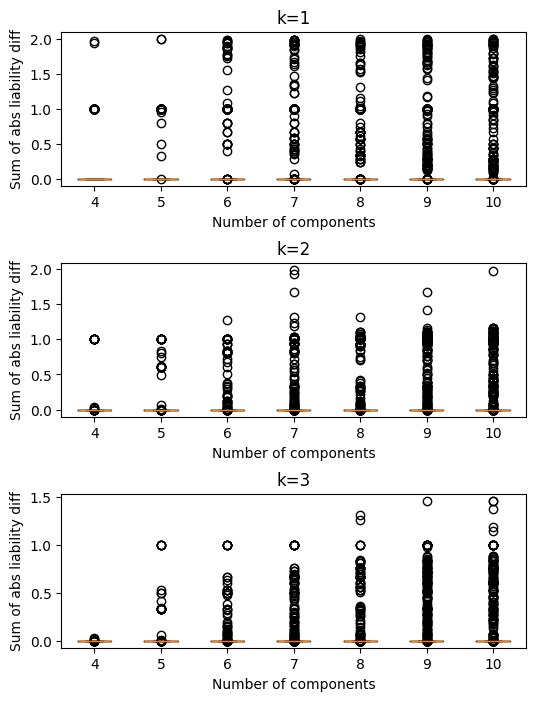

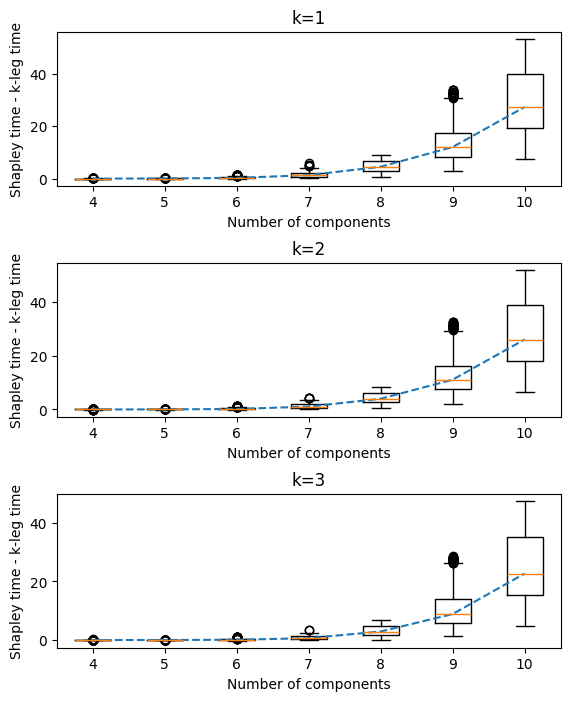

In [4]:
plots_box_plots(range(4,11),ks=[1,2,3],pickle_dir=pickle_dir)

# cur

In [9]:
for M in range(4,11):
    print(M)
    experiment_and_plot(M, ks=[1,2,3], num_samples=1000, use_pickle=True, pickle_dir='..')

4


FileNotFoundError: [Errno 2] No such file or directory: '..\\num_vars=4_ks=[1, 2, 3, 4].pickle'

In [13]:
exp_results_M5.keys()

dict_keys(['k_leg_values', 'shapley_values', 'k_leg_times', 'shapley_times'])

In [88]:
# mannwhitneyu problem (fixed)
# for d in [1,2,3,10,300]:
#     x = np.random.normal(loc=6, scale=0.5, size=1000)
#     y = np.random.normal(loc=6+d, scale=0.5, size=1000)
#     U_lt, p_value = mannwhitneyu(x, y, alternative='less')
#     U_neq, p_value = mannwhitneyu(x, y, alternative='two-sided')

#     print(f'{d=}, {U_lt=}, {U_neq=}')

d=1, U_lt=np.float64(83161.0), U_neq=np.float64(83161.0)
d=2, U_lt=np.float64(3202.0), U_neq=np.float64(3202.0)
d=3, U_lt=np.float64(7.0), U_neq=np.float64(7.0)
d=10, U_lt=np.float64(0.0), U_neq=np.float64(0.0)
d=300, U_lt=np.float64(0.0), U_neq=np.float64(0.0)
